# Stroke Risk

## Analysis of and stroke-risk calculation with patient data, including hypertension, heart-disease, glucose-level

## Disease understanding

Stroke is one of the cardiovascular diseases that cause about half of all deaths in the western world. When a stroke occurs, quick action is important. In an emergency, every minute counts.
There are several factors that can cause a stroke, including high blood pressure and high blood sugar levels.
In my work as a medical journalist, I have written about them time and again. Here I want to prove with data that stroke factors actually increase the risk.

## Analytic Approach

Visualization alone should make it possible to identify correlations. Furthermore, models should be created to determine the risk of a stroke. I start with simple linear regressions and end with neural networks. The latter might be too much effort. But it costs nothing, so to speak.

All analysis falls under the supervised learning category.

## Data requirements

I've got a dataset in csv-format of unknown source. As this is just a demo, it seems okay to use it. The data looks very clean, no data cleaning is necessary. For machine learning models, some adjustments need to be done (conversions, etc.)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
stroke = pd.read_csv('stroke_data.csv')

## Data exploration

In [3]:
stroke.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0
1,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0
2,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0
3,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0
4,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0
5,Female,74.0,1,0,Yes,Self-employed,Urban,205.84,54.6,never smoked,0
6,Male,79.0,0,1,Yes,Private,Urban,57.08,22.0,formerly smoked,0
7,Female,37.0,0,0,Yes,Private,Rural,162.96,39.4,never smoked,0
8,Female,37.0,0,0,Yes,Private,Rural,73.50,26.1,formerly smoked,0
9,Female,40.0,0,0,Yes,Private,Rural,95.04,42.4,never smoked,0


In [4]:
stroke.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29065 entries, 0 to 29064
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             29065 non-null  object 
 1   age                29065 non-null  float64
 2   hypertension       29065 non-null  int64  
 3   heart_disease      29065 non-null  int64  
 4   ever_married       29065 non-null  object 
 5   work_type          29065 non-null  object 
 6   Residence_type     29065 non-null  object 
 7   avg_glucose_level  29065 non-null  float64
 8   bmi                29065 non-null  float64
 9   smoking_status     29065 non-null  object 
 10  stroke             29065 non-null  int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 2.4+ MB


... no missing data, data types seem to be good.

### Feature description

id: patient id
Not relevant for this analysis

gender: gender of patient
Relevant, as there are differences between male and female in the course of stroke 

age: age of patient
Relevant, as age is a major risk factor

hypertension: 0 = no hypertension, 1 = suffering from hypertension
Relevant, as hypertension is a major risk factor. Allthough differentiated values would be preferable, as a mild hypertension affects the risk less than significant elevated values

heart_disease: 0 = no heart disease, 1 = suffering from heart disease
Relevant, as heart diseases are a major risk. Also here differentation would be preferable. There are several forms of heart disease

ever_married: yes/no
Relevant, as there are observartions, that married people have a lower risk of stroke/heart diseases

work_type: type of occupation
Relevant, as different types of occupation come along with higher/lower stress levels. Stress is a risk factor

Residence_type: area type of residence (rural, urban)
Maybe relevant, data will show

avg_glucose_level: average glucose level (measured after meal)
Relevant, as this is a measure of diabetes yes/no, which is a major risk

bmi: body mass index
Relevant, as the bmi is a index for overweight, a major risk factor

smoking_status: patient's smoking status
Relevant, as smokers have a higher risk

In [5]:
stroke.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
age,29065.0,47.676174,18.732941,10.00,32.00,48.00,62.00,82.00
hypertension,29065.0,0.111509,0.314766,0.00,0.00,0.00,0.00,1.00
heart_disease,29065.0,0.052159,0.222351,0.00,0.00,0.00,0.00,1.00
avg_glucose_level,29065.0,106.405639,45.272453,55.01,77.63,92.13,113.91,291.05
bmi,29065.0,30.054684,7.193951,10.10,25.00,28.90,33.90,92.00
stroke,29065.0,0.018854,0.136013,0.00,0.00,0.00,0.00,1.00


There are several possibilities to examine the data in more detail with the aim of confirming known statements from medicine. Let's do it.

First group data into age-bins, create a new df from it and count them.

In [6]:
bins = np.linspace(min(stroke['age']), max(stroke['age']), 10)
stroke['age_bin'] = pd.cut(stroke['age'], bins, include_lowest=True)

In [7]:
age_bins_list = stroke.groupby(['age_bin'])['age'].count()

In [8]:
age_bin_df = pd.DataFrame(age_bins_list)

In [9]:
age_bin_df

,age
age_bin,
"(9.999, 18.0]",1693
"(18.0, 26.0]",3061
"(26.0, 34.0]",3401
"(34.0, 42.0]",3500
"(42.0, 50.0]",4139
"(50.0, 58.0]",4284
"(58.0, 66.0]",3634
"(66.0, 74.0]",2492
"(74.0, 82.0]",2861


In [10]:
age_bin_df.rename(columns = {'age': 'Counts'}, inplace=True)

1. Hypertension affects more often older people

In [11]:
age_bin_df['Hypertension'] = stroke.groupby(['age_bin'])['hypertension'].sum()

In [12]:
age_bin_df

,Counts,Hypertension
age_bin,,
"(9.999, 18.0]",1693,3
"(18.0, 26.0]",3061,21
"(26.0, 34.0]",3401,86
"(34.0, 42.0]",3500,207
"(42.0, 50.0]",4139,411
"(50.0, 58.0]",4284,592
"(58.0, 66.0]",3634,678
"(66.0, 74.0]",2492,530
"(74.0, 82.0]",2861,713


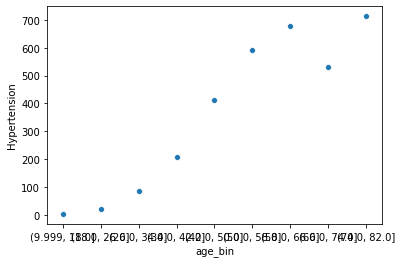

In [13]:
x = age_bin_df.index.astype(str)
sns.scatterplot(x=x, y='Hypertension', data=age_bin_df)

... it can be clearly seen that mainly people from the early mid-40s are affected by high blood pressure

2. Overweight affects more often older people

In [14]:
age_bin_df['BMI'] = stroke.groupby(['age_bin'])['bmi'].mean()

In [15]:
age_bin_df

,Counts,Hypertension,BMI
age_bin,,,
"(9.999, 18.0]",1693,3,24.986592
"(18.0, 26.0]",3061,21,27.702581
"(26.0, 34.0]",3401,86,30.027962
"(34.0, 42.0]",3500,207,31.088000
"(42.0, 50.0]",4139,411,31.290795
"(50.0, 58.0]",4284,592,31.457750
"(58.0, 66.0]",3634,678,31.420941
"(66.0, 74.0]",2492,530,30.407624
"(74.0, 82.0]",2861,713,28.405907


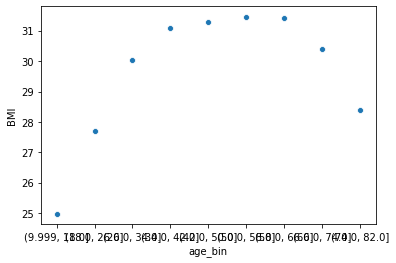

In [16]:
x = age_bin_df.index.astype(str)
sns.scatterplot(x=x, y='BMI', data=age_bin_df)

... as expected, the mean BMI increases with age. BMI over 25 is critical, over 30 equals obesity

Let's have a look at how many people in the age-bins have obesity, aka BMI over 30.

In [17]:
mask = stroke['bmi'] >= 30
stroke[mask].groupby(['age_bin'])['age'].count()

age_bin
(9.999, 18.0]     313
(18.0, 26.0]      877
(26.0, 34.0]     1431
(34.0, 42.0]     1686
(42.0, 50.0]     2134
(50.0, 58.0]     2273
(58.0, 66.0]     1938
(66.0, 74.0]     1199
(74.0, 82.0]      983
Name: age, dtype: int64

... between 42 and 66 more than half are obese!

3. High glucose levels (Diabetes) affects more often older people

In [18]:
age_bin_df['Glucose'] = stroke.groupby(['age_bin'])['avg_glucose_level'].mean()

In [19]:
age_bin_df

,Counts,Hypertension,BMI,Glucose
age_bin,,,,
"(9.999, 18.0]",1693,3,24.986592,92.498317
"(18.0, 26.0]",3061,21,27.702581,93.054724
"(26.0, 34.0]",3401,86,30.027962,96.439233
"(34.0, 42.0]",3500,207,31.088000,99.500840
"(42.0, 50.0]",4139,411,31.290795,101.961309
"(50.0, 58.0]",4284,592,31.457750,110.893182
"(58.0, 66.0]",3634,678,31.420941,116.995815
"(66.0, 74.0]",2492,530,30.407624,121.421148
"(74.0, 82.0]",2861,713,28.405907,122.393715


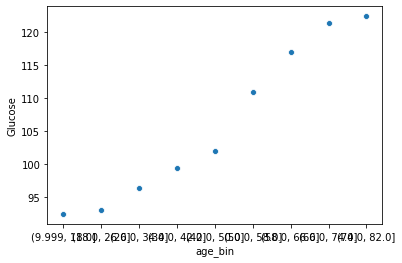

In [20]:
x = age_bin_df.index.astype(str)
sns.scatterplot(x=x, y='Glucose', data=age_bin_df)

Let's have a look at how many people in the age-bins have diabetes, aka glucose leves over 140.

In [21]:
mask = stroke['avg_glucose_level'] >= 140
stroke[mask].groupby(['age_bin'])['age'].count()

age_bin
(9.999, 18.0]     95
(18.0, 26.0]     153
(26.0, 34.0]     261
(34.0, 42.0]     360
(42.0, 50.0]     528
(50.0, 58.0]     826
(58.0, 66.0]     910
(66.0, 74.0]     708
(74.0, 82.0]     830
Name: age, dtype: int64

... quite a lot actually. And these are only the known cases. The dark figure is high.

Let's try another thing: Women seems to get heart-diseases and stroke later in life then men.

In [22]:
mask = stroke['gender'] == 'Female'
len(stroke[mask])

17852

In [23]:
mask = stroke['gender'] == 'Male'
len(stroke[mask])

11213

We have to take into account that there are far more women in this data than men.

In [24]:
mask = stroke['gender'] == 'Female'
age_bin_df['stroke_female_percentage'] = (stroke[mask].groupby(['age_bin'])['age'].count().values)/17852

In [25]:
mask = stroke['gender'] == 'Male'
age_bin_df['stroke_male_percentage'] = (stroke[mask].groupby(['age_bin'])['age'].count().values)/11213

In [26]:
age_bin_df

,Counts,Hypertension,BMI,Glucose,stroke_female_percentage,stroke_male_percentage
age_bin,,,,,,
"(9.999, 18.0]",1693,3,24.986592,92.498317,0.053271,0.066173
"(18.0, 26.0]",3061,21,27.702581,93.054724,0.117074,0.086596
"(26.0, 34.0]",3401,86,30.027962,96.439233,0.126933,0.101222
"(34.0, 42.0]",3500,207,31.088000,99.500840,0.123460,0.115580
"(42.0, 50.0]",4139,411,31.290795,101.961309,0.140264,0.145813
"(50.0, 58.0]",4284,592,31.457750,110.893182,0.143457,0.153661
"(58.0, 66.0]",3634,678,31.420941,116.995815,0.117466,0.137073
"(66.0, 74.0]",2492,530,30.407624,121.421148,0.080607,0.093909
"(74.0, 82.0]",2861,713,28.405907,122.393715,0.097468,0.099973


... in very young years (for a stroke) women seem to be more at a risk. Beginning from 40 to 45, men are more at a risk. From the seventies on the risk equalies.

Okay, one last analysis here, kinda funny: Check the features comparing married with unmarried people. Because that's what they say: Married people live healthier. We'll see!

Let's check this with the BMI ... so the body weight.

In [27]:
mask = stroke['ever_married'] == 'Yes'
len(stroke[mask])

21687

In [28]:
mask = stroke['ever_married'] == 'No'
len(stroke[mask])

7378

In [29]:
mask = stroke['ever_married'] == 'Yes'
mask2 = stroke['bmi'] > 25
age_bin_df['married_high_bmi'] = (stroke[mask & mask2].groupby(['age_bin'])['age'].count().values)/21687

In [30]:
mask = stroke['ever_married'] == 'No'
age_bin_df['not_married_high_bmi'] = (stroke[mask & mask2].groupby(['age_bin'])['age'].count().values)/7378

In [31]:
age_bin_df

,Counts,Hypertension,BMI,Glucose,stroke_female_percentage,stroke_male_percentage,married_high_bmi,not_married_high_bmi
age_bin,,,,,,,,
"(9.999, 18.0]",1693,3,24.986592,92.498317,0.053271,0.066173,0.000046,0.089049
"(18.0, 26.0]",3061,21,27.702581,93.054724,0.117074,0.086596,0.018029,0.188533
"(26.0, 34.0]",3401,86,30.027962,96.439233,0.126933,0.101222,0.069443,0.129574
"(34.0, 42.0]",3500,207,31.088000,99.500840,0.123460,0.115580,0.103610,0.064787
"(42.0, 50.0]",4139,411,31.290795,101.961309,0.140264,0.145813,0.137963,0.044999
"(50.0, 58.0]",4284,592,31.457750,110.893182,0.143457,0.153661,0.152303,0.032258
"(58.0, 66.0]",3634,678,31.420941,116.995815,0.117466,0.137073,0.133490,0.025346
"(66.0, 74.0]",2492,530,30.407624,121.421148,0.080607,0.093909,0.089639,0.015045
"(74.0, 82.0]",2861,713,28.405907,122.393715,0.097468,0.099973,0.084290,0.027514


... looks like marriage makes you fat in the long run. Oops!

Okay, let's check for some correlations. As the correlations are well known, it will be interesting to see them confirmed in the data. For these analysis we need to transform categorical data into numbers.

In [32]:
stroke['gender_number'] = stroke['gender'].replace(to_replace=['Male', 'Female'], value=[0,1])

In [33]:
stroke['married_number'] = stroke['ever_married'].replace(to_replace=['Yes', 'No'], value=[0,1])

In [34]:
stroke['work_type_numbers'] = stroke['work_type'].replace(to_replace=['Private', 'Self-employed', 'Govt_job', 'Never_worked', 'children'], value=[0,1,2,3,4])

In [35]:
stroke['residence_type_numbers'] = stroke['Residence_type'].replace(to_replace=['Rural', 'Urban'], value=[0,1])

In [36]:
stroke['smoker_numbers'] = stroke['smoking_status'].replace(to_replace=['never smoked', 'formerly smoked', 'smokes'], value=[0,1,2])

In [37]:
stroke.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke,age_bin,gender_number,married_number,work_type_numbers,residence_type_numbers,smoker_numbers
0,Male,58.0,1,0,Yes,Private,Urban,87.96,39.2,never smoked,0,"(50.0, 58.0]",0,0,0,1,0
1,Female,70.0,0,0,Yes,Private,Rural,69.04,35.9,formerly smoked,0,"(66.0, 74.0]",1,0,0,0,1
2,Female,52.0,0,0,Yes,Private,Urban,77.59,17.7,formerly smoked,0,"(50.0, 58.0]",1,0,0,1,1
3,Female,75.0,0,1,Yes,Self-employed,Rural,243.53,27.0,never smoked,0,"(74.0, 82.0]",1,0,1,0,0
4,Female,32.0,0,0,Yes,Private,Rural,77.67,32.3,smokes,0,"(26.0, 34.0]",1,0,0,0,2


Also here, already setting up a dataframe with dummies for machine learning steps later on

In [38]:
stroke_ml = pd.get_dummies(stroke, columns=['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status'], prefix=['gender', 'married', 'work', 'residence', 'smoker'])

In [39]:
stroke_ml.head()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke,age_bin,gender_number,married_number,work_type_numbers,...,work_Govt_job,work_Never_worked,work_Private,work_Self-employed,work_children,residence_Rural,residence_Urban,smoker_formerly smoked,smoker_never smoked,smoker_smokes
0,58.0,1,0,87.96,39.2,0,"(50.0, 58.0]",0,0,0,...,0,0,1,0,0,0,1,0,1,0
1,70.0,0,0,69.04,35.9,0,"(66.0, 74.0]",1,0,0,...,0,0,1,0,0,1,0,1,0,0
2,52.0,0,0,77.59,17.7,0,"(50.0, 58.0]",1,0,0,...,0,0,1,0,0,0,1,1,0,0
3,75.0,0,1,243.53,27.0,0,"(74.0, 82.0]",1,0,1,...,0,0,0,1,0,1,0,0,1,0
4,32.0,0,0,77.67,32.3,0,"(26.0, 34.0]",1,0,0,...,0,0,1,0,0,1,0,0,0,1


So here we go with the correlation analysis ...

In [40]:
stroke[['gender_number', 'age', 'hypertension', 'heart_disease', 'married_number', 'work_type_numbers', 'residence_type_numbers', 'avg_glucose_level', 'bmi', 'smoker_numbers', 'stroke']].corr()

,gender_number,age,hypertension,heart_disease,married_number,work_type_numbers,residence_type_numbers,avg_glucose_level,bmi,smoker_numbers,stroke
gender_number,1.000000,-0.040595,-0.036748,-0.097634,0.024907,-0.025738,-0.006438,-0.050701,-0.021646,-0.091155,-0.012257
age,-0.040595,1.000000,0.257536,0.247430,-0.547131,-0.045517,0.003480,0.228283,0.106226,0.060343,0.154059
hypertension,-0.036748,0.257536,1.000000,0.117962,-0.130782,-0.000966,-0.002871,0.154052,0.129283,0.008762,0.078674
heart_disease,-0.097634,0.247430,0.117962,1.000000,-0.095226,0.001176,-0.003127,0.137482,0.022740,0.062739,0.105142
married_number,0.024907,-0.547131,-0.130782,-0.095226,1.000000,0.072390,-0.004918,-0.117362,-0.143129,-0.070319,-0.047724
work_type_numbers,-0.025738,-0.045517,-0.000966,0.001176,0.072390,1.000000,-0.008029,0.001578,-0.063215,-0.056140,-0.001518
residence_type_numbers,-0.006438,0.003480,-0.002871,-0.003127,-0.004918,-0.008029,1.000000,-0.002574,-0.002898,0.006279,0.001962
avg_glucose_level,-0.050701,0.228283,0.154052,0.137482,-0.117362,0.001578,-0.002574,1.000000,0.176936,0.025987,0.075447
bmi,-0.021646,0.106226,0.129283,0.022740,-0.143129,-0.063215,-0.002898,0.176936,1.000000,0.021148,-0.004039
smoker_numbers,-0.091155,0.060343,0.008762,0.062739,-0.070319,-0.056140,0.006279,0.025987,0.021148,1.000000,0.011148


As expected, correlations between: age and hypertension, heart-disease, glucose-level and bmi. There are also other correlations, though expected, not that clear. I suppose we will get good models from the data.

## Modelling

### Chosing algos

Some thoughts on the algorithms:
One can expect some linear correlations, e.g. BMI, sugar levels, age, etc.
Also some features should be good for logistic classification, e.g. the features gender, hypertension, heart-disease, who are true or false.
We don't want to miss other classifications like K-Means.
Decision trees should be tried.

So this is the approach: First try all features together and see what happens. Then pick up the features good for linear regression and compare them to the all-features-outcome. Finally I will try a neural network.

In [41]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.model_selection import cross_val_score, RepeatedKFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

### All features: Define features

In [42]:
X = stroke_ml.drop(['stroke', 'age_bin'], axis=1).values

In [43]:
y = stroke_ml['stroke'].values

### Split into train and test

In [44]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)

### Scaling

In [45]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

### Linear Regression

In [46]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [47]:
print(model.score(X_test_scaled, y_test))

0.03444532957940205


This is not a good result! Well, let's try a K-Fold Cross Validation, just to confirm

### Linear Regression with K-Fold Cross Validation

In [48]:
scores = cross_val_score(LinearRegression(), X, y, cv = RepeatedKFold(n_repeats=100))

In [49]:
print(np.mean(scores))

0.031593321228083976


Didn't make it better.

### Multinomial Logistic Regression

In [50]:
model = LogisticRegression(multi_class = 'multinomial', solver = 'newton-cg')
model.fit(X_train_scaled, y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='multinomial', n_jobs=None, penalty='l2',
                   random_state=None, solver='newton-cg', tol=0.0001, verbose=0,
                   warm_start=False)

In [51]:
print(model.score(X_test_scaled, y_test))

0.9811476537773497


Looking good so far! For the sake of completeness MLR with sag- and saga-solver.

In [52]:
model = LogisticRegression(multi_class = 'multinomial', solver = 'sag')
model.fit(X_train_scaled, y_train)
print(model.score(X_test_scaled, y_test))

0.9811476537773497


/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/sklearn/linear_model/_sag.py:330: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


In [53]:
model = LogisticRegression(multi_class = 'multinomial', solver = 'saga', max_iter = 400)
model.fit(X_train_scaled, y_train)
print(model.score(X_test_scaled, y_test))

0.9811476537773497


### K-Neighbors Classifier

In [54]:
model = KNeighborsClassifier(n_neighbors = 15)
model.fit(X_train_scaled, y_train)
print(model.score(X_test_scaled, y_test))

0.9811476537773497


### Decision Tree

In [55]:
model = DecisionTreeClassifier(criterion = 'entropy')
model.fit(X_train, y_train)
print(model.score(X_test, y_test))

0.9617448740883445


As this score is lower than the ones before, i refrain from a visualisation at this point.

### Random Forest

In [56]:
model = RandomForestClassifier(criterion = 'entropy', n_estimators = 15)
model.fit(X_train_scaled, y_train)
print(model.score(X_test_scaled, y_test))

0.9805972203109949


### SVM

In [57]:
model = SVC(kernel = 'rbf', gamma = 0.01, C = 1)
model.fit(X_train_scaled, y_train)
print(model.score(X_test_scaled, y_test))

0.9811476537773497


In [58]:
model = SVC(kernel = 'poly', degree = 2, coef0 = 1)
model.fit(X_train_scaled, y_train)
print(model.score(X_test_scaled, y_test))

0.9811476537773497


Resumee: The results were nearly identical - and quite good. The winner would be the polynomial regression, as this should be the fastest.

### Linear Regression with only linear features

In [59]:
X = stroke_ml[['age', 'bmi', 'avg_glucose_level']].values

Just three features, but let's see the results

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 0, test_size = 0.25)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [61]:
model = LinearRegression()
model.fit(X_train_scaled, y_train)
print(model.score(X_test_scaled, y_test))

0.02805408938033216


... okay, even worse than with all features. This didn't work at all.

### Neural Network with Keras (Tensorflow)

Polynomial Regression did a great job. But maybe there is a small improvement with a neural network.

In [62]:
import keras

New feature set with all features

In [81]:
X = stroke_ml.drop(['stroke', 'age_bin'], axis=1).values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25)
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [82]:
X.shape

(29065, 24)

Model definition

In [83]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(units = 24, input_dim = 24, activation = 'relu'))
model.add(keras.layers.Dense(units = 12, activation = 'relu'))
model.add(keras.layers.Dense(units = 1))

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 24)                600       
_________________________________________________________________
dense_10 (Dense)             (None, 12)                300       
_________________________________________________________________
dense_11 (Dense)             (None, 1)                 13        
Total params: 913
Trainable params: 913
Non-trainable params: 0
_________________________________________________________________


In [84]:
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [85]:
early_stopping = keras.callbacks.EarlyStopping(monitor = 'loss', patience = 5)
checkpoints = keras.callbacks.ModelCheckpoint(filepath = 'stroke_model.h5', monitor = 'loss', save_best_only = True)
callbacks = [early_stopping, checkpoints]

Train model

In [86]:
history = model.fit(X_train_scaled, y_train, epochs = 20, batch_size = 8, validation_data = (X_test_scaled, y_test), callbacks = callbacks)

Epoch 1/20
2725/2725 [==============================] - 2s 622us/step - loss: 0.2848 - accuracy: 0.9811 - val_loss: 0.2993 - val_accuracy: 0.9806
Epoch 2/20
2725/2725 [==============================] - 2s 585us/step - loss: 0.2873 - accuracy: 0.9813 - val_loss: 0.2993 - val_accuracy: 0.9806
Epoch 3/20
2725/2725 [==============================] - 2s 585us/step - loss: 0.2880 - accuracy: 0.9813 - val_loss: 0.2993 - val_accuracy: 0.9806
Epoch 4/20
2725/2725 [==============================] - 2s 584us/step - loss: 0.2880 - accuracy: 0.9813 - val_loss: 0.2993 - val_accuracy: 0.9806
Epoch 5/20
2725/2725 [==============================] - 2s 585us/step - loss: 0.2880 - accuracy: 0.9813 - val_loss: 0.2993 - val_accuracy: 0.9806
Epoch 6/20
2725/2725 [==============================] - 2s 585us/step - loss: 0.2880 - accuracy: 0.9813 - val_loss: 0.2993 - val_accuracy: 0.9806


Validation

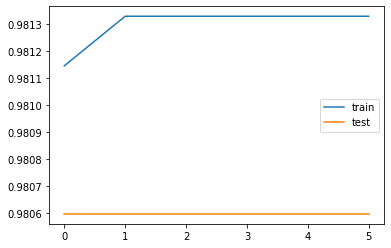

In [87]:
acc_train = history.history['accuracy']
acc_test = history.history['val_accuracy']
x_achse = list(range(len(acc_train)))
plt.plot(x_achse, acc_train, label = 'train')
plt.plot(x_achse, acc_test, label = 'test')
plt.legend()

Summary: The score is nearly identical to the other models above. As expected, setting up a neural network didn't improve the results. As neural networks are more time and resource consuming, it's not worth it.

## Resumee

So it worked out: I was able to show that stroke factors actually increase the risk. I am not working as a health journalist anymore. But very glad that all the stuff I wrote in the past were actually true. Well, I wasn't expecting anything else. What I wrote in the past weren't my own thoughts, but the infos from doctors and other experts. And their saying were also based on data - of course. Data matters!